In [10]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    explained_variance_score,
    r2_score,
    mean_squared_error)

# Geospatial packages
import geopandas as gpd
from shapely import Point
from pysal.explore import esda
from libpysal.weights import Queen, lag_spatial, KNN
from splot.esda import moran_scatterplot, lisa_cluster

# Modelo de regresón lineal sin agregación en H3

El modelo de este notebook utiliza técnicas convencionales de aprendizaje automático para un regresión lineal.

El tratamiento del componente geoespacial, es decir, los elementos de malla hexagonales de H3, se incorpora al modelo utilizando _One Hot Encoding_ de los elementos de la malla.

## Carga de datos

In [2]:
# Ruta a archivos de datos
DATA_PATH = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'datos-produccion-maiz',
    'agg-maize-panel-rcp2p6.csv')

H3_CATALOGUE = os.path.join(
    os.path.dirname(os.getcwd()),
    'data',
    'datos-produccion-maiz',
    '01_h3_cells_catalogue.csv')

# Carga de datos
data = pd.read_csv(DATA_PATH)
cat_h3 = pd.read_csv(H3_CATALOGUE)
h3_res = 'hex_3'

# Unir resolución de malla a datos
data = (
    data
    .join(
        other=cat_h3[['id',h3_res]]
        ,on='id'
        ,how='left'
        ,rsuffix='__ignore')
    .drop(columns=['id__ignore'])
    .dropna(axis=0))

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94221 entries, 0 to 94222
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             94221 non-null  int64  
 1   lon            94221 non-null  float64
 2   lat            94221 non-null  float64
 3   mean_precip    94221 non-null  float64
 4   mean_precip_2  94221 non-null  float64
 5   mean_temp      94221 non-null  float64
 6   mean_temp_2    94221 non-null  float64
 7   mean_yield     94221 non-null  float64
 8   period         94221 non-null  object 
 9   hex_3          94221 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 7.9+ MB


## Partición en Train y Test

In [5]:
# Definición de variable objetivo
target = 'mean_yield'

# Partición de conjuntos de datos
# Estructura de predictores
# 0: mean_precip
# 1: mean_precip_2
# 2: mean_temp
# 3: mean_temp_2
# 4...: hex_3 en OHE
x_train = (
    data
    .query("period in ['2005-2035','2035-2065']")
    .drop(columns=['id','lon','lat','period',target])
    .to_numpy())
y_train = (
    data
    .query("period in ['2005-2035','2035-2065']")
    .filter(items=[target])
    .to_numpy())

x_test = (
    data
    .query("period == '2065-2099'")
    .drop(columns=['id','lon','lat','period', target])
    .to_numpy())
y_test = (
    data
    .query("period == '2065-2099'")
    .filter(items=[target])
    .to_numpy())

print(
    f"""Datasets dimensions:
    x_train: {x_train.shape}
    y_train: {y_train.shape}
    x_test: {x_test.shape}
    y_test: {y_test.shape}""")

Datasets dimensions:
    x_train: (62814, 5)
    y_train: (62814, 1)
    x_test: (31407, 5)
    y_test: (31407, 1)


## Ingeniería de características

In [6]:
# Iniciar objeto encoder
ohe = OneHotEncoder(
    drop='first',
    handle_unknown='error',
    sparse_output=False)

# Ajustar encoder
ohe.fit(cat_h3[h3_res].unique().reshape((-1,1)))

# Transformar conjuntos train y test
x_train = np.hstack((
    np.delete(arr=x_train, obj=4, axis=1),
    ohe.transform(X=x_train[:,4].reshape((-1,1))) ))
x_test = np.hstack((
    np.delete(arr=x_test, obj=4, axis=1),
    ohe.transform(X=x_test[:,4].reshape((-1,1))) ))

# Inspeccionar dimensiones
x_train.shape, x_test.shape

((62814, 8214), (31407, 8214))

## Modelo de regresión lineal

Entrenamiento de modelo

Tiempo de procesamiento: [`6min 48s`, `7min 38s`, `7min 34s`]

In [8]:
# Iniciar instancia de modelo
ols = LinearRegression(
    fit_intercept=True,
    n_jobs=-1)

# Entrenamiento
ols.fit(X=x_train, y=y_train)

LinearRegression(n_jobs=-1)

Coeficiente de determinación para datos de entrenamiento

$R^2 = 0.956334$

In [9]:
ols.score(X=x_train, y=y_train)

0.9563346525301238

Otras métricas de desempeño dentro del conjunto de entramiento

In [10]:
y_pred = ols.predict(X=x_train)

In [11]:
var_score_train = explained_variance_score(y_true=y_train, y_pred=y_pred)
r2_train = r2_score(y_true=y_train, y_pred=y_pred)
rmse_train = mean_squared_error(y_true=y_train, y_pred=y_pred)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_train:.2f} %
    coef. determinación: {r2_train:.6f}
    RMSE: {np.sqrt(rmse_train):.6f}""")

Métricas en train:
    varianza explicada: 95.63 %
    coef. determinación: 0.956335
    RMSE: 0.700559


## Desempeño en Test

In [12]:
y_pred = ols.predict(X=x_test)

In [13]:
var_score_test = explained_variance_score(y_true=y_test, y_pred=y_pred)
r2_test = r2_score(y_true=y_test, y_pred=y_pred)
rmse_test = mean_squared_error(y_true=y_test, y_pred=y_pred)

print(
    f"""Métricas en train:
    varianza explicada: {100*var_score_test:.2f} %
    coef. determinación: {r2_test:.6f}
    RMSE: {np.sqrt(rmse_test):.6f}""")

Métricas en train:
    varianza explicada: 95.03 %
    coef. determinación: 0.950279
    RMSE: 0.739847


# Normalidad geoespacial de residuales

## Datos expandidos

In [2]:
out_path = os.path.join(
    '..','data',
    'models_output',
    '01_ols_regression.csv')

In [15]:
residual_test = (
    data
    .query("period == '2065-2099'")
    .assign(
        mean_yield_pred = y_pred,
        residuals = lambda df: df.mean_yield_pred - df.mean_yield))

residual_test.to_csv(out_path, index=False)

Carga de datos expandidos leyendo el archivo de salida del modelo

In [3]:
# Carga de datos expandidos
residual_test = pd.read_csv(out_path)

# Definir columna de geometría
geometry = gpd.GeoSeries(
    data=residual_test.apply(
        func=lambda df: Point((df.lon, df.lat)),
        axis=1))

# Conversión a GeoPandas
residual_test = gpd.GeoDataFrame(data=residual_test, geometry=geometry)

# Asignar CRS
residual_test.crs = 'EPSG:4326'

residual_test.head()

,id,lon,lat,mean_precip,mean_precip_2,mean_temp,mean_temp_2,mean_yield,period,hex_3,mean_yield_pred,residuals,geometry
0,1,-128.75,54.25,190.444427,54862.181776,7.804710,112.890992,3.524696,2065-2099,831284fffffffff,3.435467,-0.089229,POINT (-128.75000 54.25000)
1,2,-128.75,54.75,106.560491,16800.366451,6.571009,102.951142,2.802876,2065-2099,8312a2fffffffff,2.735325,-0.067550,POINT (-128.75000 54.75000)
2,3,-128.75,55.75,125.628080,23525.656879,6.060377,113.340650,2.557030,2065-2099,83129afffffffff,2.525273,-0.031758,POINT (-128.75000 55.75000)
3,4,-128.25,50.75,293.912360,118260.797323,10.605312,127.296821,4.206531,2065-2099,831298fffffffff,4.616246,0.409715,POINT (-128.25000 50.75000)
4,5,-128.25,51.75,285.466420,112295.478936,10.128092,127.814835,4.747389,2065-2099,83129cfffffffff,4.377287,-0.370101,POINT (-128.25000 51.75000)


## Rezago espacial

Primero se define la matriz de pesos utilizando el criterio de contigüidad kNN dado que son puntos de coordenadas

In [14]:
residual_test.geometry

0        POINT (-128.75000 54.25000)
1        POINT (-128.75000 54.75000)
2        POINT (-128.75000 55.75000)
3        POINT (-128.25000 50.75000)
4        POINT (-128.25000 51.75000)
                    ...             
31402    POINT (177.75000 -38.75000)
31403    POINT (177.75000 -38.25000)
31404    POINT (177.75000 -37.75000)
31405    POINT (178.25000 -38.75000)
31406    POINT (178.25000 -38.25000)
Name: geometry, Length: 31407, dtype: geometry

In [16]:
# Matriz de pesos espaciales
# W = Queen.from_dataframe(
#     df=residual_test,
#     geom_col='geometry',
#     silence_warnings=True)
W = KNN.from_dataframe(
    df=residual_test,
    k=10,
    geom_col='geometry',)

# Estandarizar por renglón los pesos
W.set_transform(value='R')

c:\Users\Miguel\Documents\Github\estancia\venv\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


Ahora se calcula el rezago espacial con respecto a la variable objetivo

In [17]:
residual_test['residuals_spatial_lag'] = lag_spatial(
    w=W,
    y=residual_test.residuals)

Finalmente, se visualiza la dispersión de Moran

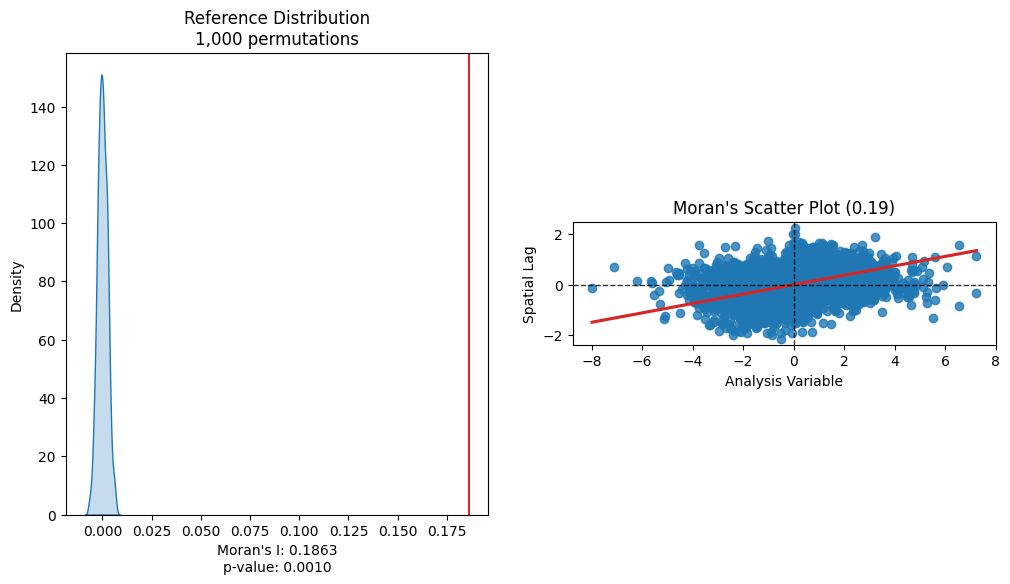

In [18]:
# Moran's I statistic instance
morans_stat = esda.moran.Moran(
    y=residual_test.residuals
    ,w=W
    ,transformation='R'
    ,permutations=1_000)

# Figure specs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# Visualization elements
sns.kdeplot(
    data=morans_stat.sim
    ,fill=True
    ,ax=ax[0])
ax[0].axvline(x=morans_stat.I, color='tab:red')
sns.regplot(
    data=residual_test
    ,x='residuals'
    ,y='residuals_spatial_lag'
    ,ci=None
    ,line_kws=dict(color='tab:red')
    ,ax=ax[1])
ax[1].axvline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')
ax[1].axhline(0, color='black', alpha=0.8, linewidth=1, linestyle='--')


# Styling
ax[0].set(
    title=f'Reference Distribution\n{morans_stat.permutations:,} permutations'
    ,xlabel=f"Moran's I: {morans_stat.I:.4f}\np-value: {morans_stat.p_sim:.4f}"
    ,ylabel='Density')
ax[1].set(
    title=f"Moran's Scatter Plot ({morans_stat.I:.2f})"
    ,xlabel='Analysis Variable'
    ,ylabel='Spatial Lag')
ax[1].set_aspect('equal')

plt.show()

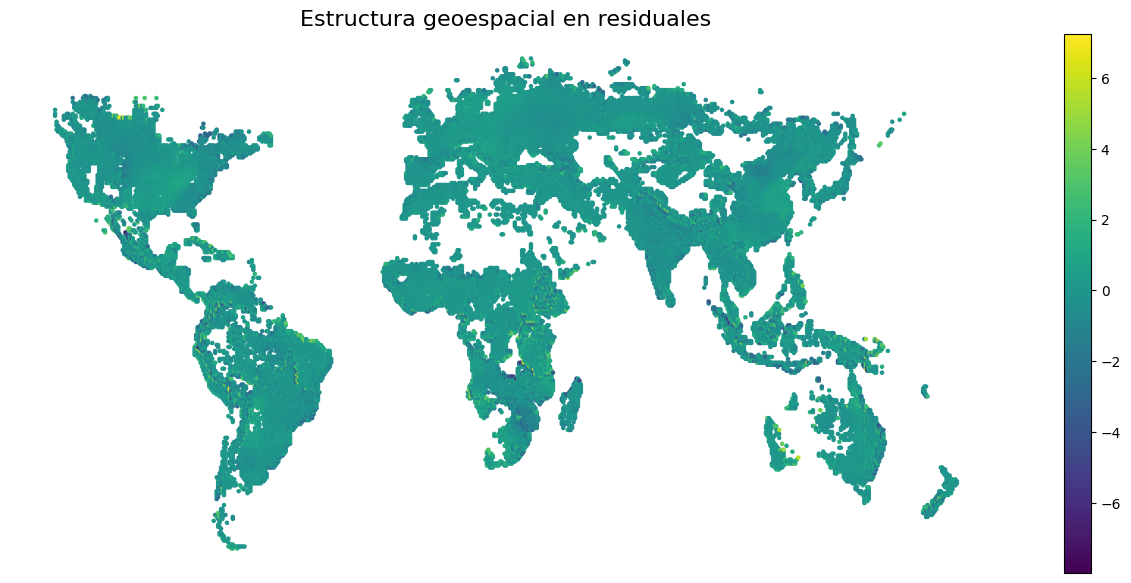

In [19]:
# Figure config
fig, ax = plt.subplots(figsize=(16,7))

# Visualization elements
map = ax.scatter(
    x=residual_test.lon
    ,y=residual_test.lat
    ,s=5
    ,c=residual_test.residuals
    ,cmap='viridis')

colorbar = plt.colorbar(map)

# Annotations and styling
ax.set_title(
    label='Estructura geoespacial en residuales'
    ,fontsize=16)
ax.set_yticks([])
ax.set_xticks([])
ax.set_frame_on(False)

plt.show()